# Housing Prices Prediction

### Ben Branchflower
This is my submission to the [Housing Price Prediction Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). 

In [68]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [39]:
train = pd.read_csv('house_train.csv')
train_id = train.Id
train.drop(columns=['Id'], inplace=True)
print('train shape:', train.shape)
test = pd.read_csv('house_test.csv')
test_id = test.Id
test.drop(columns=['Id'], inplace=True)
print('test shape:', test.shape)
train.head()

train shape: (1460, 80)
test shape: (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [20]:
""" # this is for scaling the data and encoding categoricals which I probably should do but don't want to right now
[str(train[c].dtype) == 'object'  for c in train.columns] # this should let us know which ones to scale or not
mapper = DataFrameMapper(
  [(continuous_col, StandardScaler()) for continuous_col in continuous_cols] +
  [(categorical_col, LabelBinarizer()) for categorical_col in categorical_cols]
)
pipeline = Pipeline(
  ("mapper", mapper)
)
pipeline.fit_transform(df, df["y"])

scaler = StandardScaler() 
scaler.fit(train)
scaled_train = scaler.transform(trainf)
"""

' # this is for scaling the data and encoding categoricals which I probably should do but don;t want to right now\nmapper = DataFrameMapper(\n  [(continuous_col, StandardScaler()) for continuous_col in continuous_cols] +\n  [(categorical_col, LabelBinarizer()) for categorical_col in categorical_cols]\n)\npipeline = Pipeline(\n  ("mapper", mapper)\n)\npipeline.fit_transform(df, df["y"])\n\nscaler = StandardScaler() \nscaler.fit(train)\nscaled_train = scaler.transform(trainf)\n'

In [5]:
train.iloc[:,range(45)].describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000


In [6]:
train.iloc[:,range(45, 81)].describe()

,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


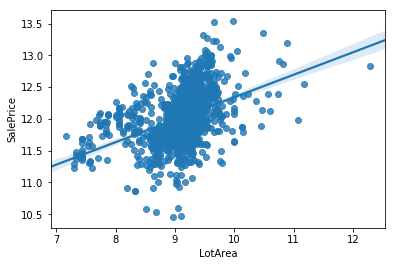

In [11]:
sns.regplot(np.log(train['LotArea']), np.log(train['SalePrice']))

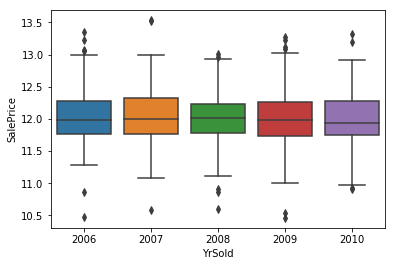

In [12]:
sns.boxplot(train['YrSold'], np.log(train['SalePrice']))

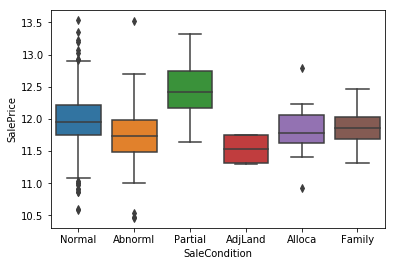

In [13]:
sns.boxplot(train['SaleCondition'], np.log(train['SalePrice']))

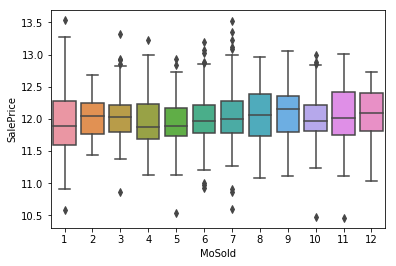

In [14]:
sns.boxplot(train['MoSold'], np.log(train['SalePrice']))

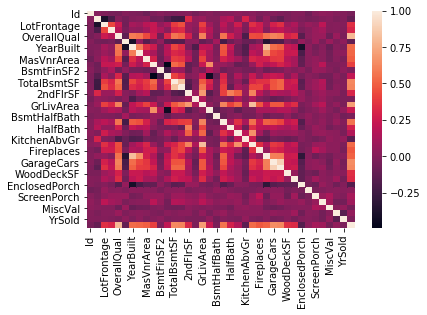

In [15]:
sns.heatmap(train.corr())

In [36]:
train.dropna(subset=['MSSubClass', 'LotFrontage', 'LotArea'], inplace=True)
reg = LinearRegression().fit(train.iloc[:,[1,3,4]], train['SalePrice'])
reg.__dict__

{'fit_intercept': True,
 'normalize': False,
 'copy_X': True,
 'n_jobs': 1,
 'coef_': array([ 99.90276728, 984.39591695,   2.101073  ]),
 '_residues': 7026954013762.121,
 'rank_': 3,
 'singular_': array([274508.07268315,   1491.97274652,    701.88591283]),
 'intercept_': 85190.08690014269}

In [54]:
sgd = SGDRegressor(tol=.00000001, eta0=0.01).fit(train.iloc[:,[3,3,6]], train['SalePrice'])
sgd.__dict__

ValueError: could not convert string to float: 'Reg'

In [79]:
clean_train = train.iloc[:,[str(train[c].dtype) != 'object' for c in train.columns]].dropna()
clean_test = test.iloc[:,[str(test[c].dtype) != 'object' for c in test.columns]].dropna()
lasso = Lasso(alpha = 0.1)
lasso.fit(clean_train.drop(columns=['SalePrice']), clean_train['SalePrice'])
mse(clean_train['SalePrice'], lasso.predict(clean_train.drop(columns=['SalePrice'])))

1311021536.3498037

In [60]:
train.iloc[:,[str(train[c].dtype) != 'object' and c != 'SalePrice' for c in train.columns]]
''

''

In [61]:
train['SalePrice']
''

''